In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Read grid info

In [28]:
diri = "C:/Users/apbarret/Documents/Posters/AGU_Fall_2016_Barrett_Stroeve/"
fili = "beaufo_2001sep03a_3c_stats_v1.0.txt"

f = open(diri+fili, 'r')

# Read through header
for il in np.arange(0,3):
    f.readline()
    
# Read column headings. 
header = f.readline()

tmp = np.genfromtxt(f)

f.close()

row = np.int8(np.mod(tmp[:,0],100.))
col = np.int8(np.floor(tmp[:,0]/100))

ice_grid = tmp[:,1].reshape(20,20)
pond_grid = tmp[:,2].reshape(20,20)
owtr_grid = tmp[:,3].reshape(20,20)

# Mask grids
import numpy.ma as ma
ice_grid = ma.masked_where(ice_grid > 9., ice_grid)
pond_grid = ma.masked_where(pond_grid > 9., pond_grid)
owtr_grid = ma.masked_where(owtr_grid > 9., owtr_grid)



#Import spectral library

In [29]:
from spectral.io import envi

# Ice
fili = "C:/Users/apbarret/Documents/data/Sheba2/Sheba.SpectralLibrary.ice.filled.hdr"
ice = envi.open(fili)

# Ponds
fili = "C:/Users/apbarret/Documents/data/Sheba2/Sheba.SpectralLibrary.pond.filled.hdr"
pond = envi.open(fili)

# Leads
fili = "C:/Users/apbarret/Documents/data/Sheba2/Sheba.SpectralLibrary.lead.filled.hdr"
lead = envi.open(fili)


#Convert to modis band reflectances

In [30]:
from seaice_albedo_utilities import modis_srf, modis_bbalbedo, spectra2modis

wv, srf = modis_srf()
ice_df = spectra2modis(ice, wv, srf, code='I')
pond_df = spectra2modis(pond, wv, srf, code='P')
lead_df = spectra2modis(lead, wv, srf, code='L')

#Calculate pixel band reflectances

In [35]:
# Select spectra id
iice = 0
ipnd = 5
iowt = 8

band1 = (ice_df['band1'][iice]*ice_grid + 
         pond_df['band1'][ipnd]*pond_grid + 
         lead_df['band1'][iowt]*owtr_grid + 
         np.random.normal(0.,0.001,ice_grid.shape))

band2 = (ice_df['band2'][iice]*ice_grid + 
         pond_df['band2'][ipnd]*pond_grid + 
         lead_df['band2'][iowt]*owtr_grid + 
         np.random.normal(0.,0.001,ice_grid.shape))

band3 = (ice_df['band3'][iice]*ice_grid + 
         pond_df['band3'][ipnd]*pond_grid + 
         lead_df['band3'][iowt]*owtr_grid + 
         np.random.normal(0.,0.001,ice_grid.shape))

band4 = (ice_df['band4'][iice]*ice_grid + 
         pond_df['band4'][ipnd]*pond_grid + 
         lead_df['band4'][iowt]*owtr_grid + 
         np.random.normal(0.,0.001,ice_grid.shape))

(20L, 20L)


#Estimate fractions

In [87]:
from seaice_albedo_utilities import find_three_surface

ice_est = np.zeros(ice_grid.shape) #ma.masked_array(ma.zeros(ice_grid.shape),mask=band1.mask)
pond_est = np.zeros(ice_grid.shape) #ma.masked_array(ma.zeros(ice_grid.shape),mask=band1.mask)
owtr_est = np.zeros(ice_grid.shape) #ma.masked_array(ma.zeros(ice_grid.shape),mask=band1.mask)
rmse_est = np.zeros(ice_grid.shape) #ma.masked_array(ma.zeros(ice_grid.shape),mask=band1.mask)

for ir in np.arange(0,20):
    for ic in np.arange(0,20):
        if ((band1[ic,ir] is not ma.masked) |
            (band2[ic,ir] is not ma.masked) |
            (band3[ic,ir] is not ma.masked) |
            (band4[ic,ir] is not ma.masked)):
            
            print 'Working on %02i %02i' % (ic, ir)
        
            surface = np.array([band1[ic,ir], band2[ic,ir], band3[ic,ir], band4[ic,ir]])
            
            farea, rmse = find_three_surface(ice_df, pond_df, lead_df, surface)
            
            best = np.argmin(np.array(rmse))
            ice_est[ic,ir] = farea[best][0]
            pond_est[ic,ir] = farea[best][1]
            owtr_est[ic,ir] = farea[best][2]
            rmse_est[ic,ir] = rmse[best]
            

Working on 12 00
Working on 13 00
Working on 14 00
Working on 15 00
Working on 07 01
Working on 08 01
Working on 09 01
Working on 10 01
Working on 11 01
Working on 12 01
Working on 13 01
Working on 14 01
Working on 15 01
Working on 02 02
Working on 03 02
Working on 04 02
Working on 05 02
Working on 06 02
Working on 07 02
Working on 08 02
Working on 09 02
Working on 10 02
Working on 11 02
Working on 12 02
Working on 13 02
Working on 14 02
Working on 15 02
Working on 16 02
Working on 00 03
Working on 01 03
Working on 02 03
Working on 03 03
Working on 04 03
Working on 05 03
Working on 06 03
Working on 07 03
Working on 08 03
Working on 09 03
Working on 10 03
Working on 11 03
Working on 12 03
Working on 13 03
Working on 14 03
Working on 15 03
Working on 16 03
Working on 00 04
Working on 01 04
Working on 02 04
Working on 03 04
Working on 04 04
Working on 05 04
Working on 06 04
Working on 07 04
Working on 08 04
Working on 09 04
Working on 10 04
Working on 11 04
Working on 12 04
Working on 13 

In [88]:
print ice_grid[17,4], pond_grid[17,4], owtr_grid[17,4]

0.11 0.05 0.85


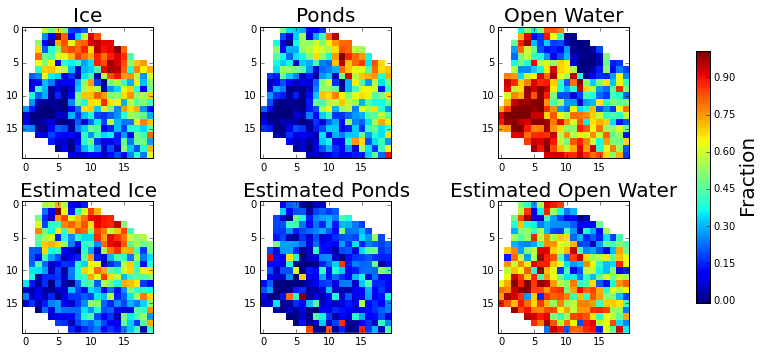

In [96]:
ice_est = ma.masked_array(ice_est,mask=ice_grid.mask)
pond_est = ma.masked_array(pond_est,mask=pond_grid.mask)
owtr_est = ma.masked_array(owtr_est,mask=owtr_grid.mask)

import matplotlib.pyplot as plt

f = plt.figure(figsize=(10,5))

a = f.add_subplot(2,3,1)
imgplt = plt.imshow(ice_grid, interpolation='none')
a.set_title('Ice', fontsize=20)

a = f.add_subplot(2,3,2)
imgplt = plt.imshow(pond_grid, interpolation='none')
a.set_title('Ponds', fontsize=20)

a = f.add_subplot(2,3,3)
imgplt = plt.imshow(owtr_grid, interpolation='none')
a.set_title('Open Water', fontsize=20)
#plt.colorbar()

a = f.add_subplot(2,3,4)
imgplt = plt.imshow(ice_est, interpolation='none')
a.set_title('Estimated Ice', fontsize=20)

a = f.add_subplot(2,3,5)
imgplt = plt.imshow(pond_est, interpolation='none')
a.set_title('Estimated Ponds', fontsize=20)

a = f.add_subplot(2,3,6)
imgplt = plt.imshow(owtr_est, interpolation='none')
a.set_title('Estimated Open Water', fontsize=20)

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.99, 0.15, 0.02, 0.7])
cbar = f.colorbar(imgplt, cax=cbar_ax)
cbar.ax.set_ylabel('Fraction', fontsize=20)

plt.tight_layout()

f.savefig('C:/Users/apbarret/Documents/Posters/AGU_Fall_2016_Barrett_Stroeve/synthetic_for_agu2016.png',
           bbox_extra_artists=(cbar_ax,), bbox_inches='tight')

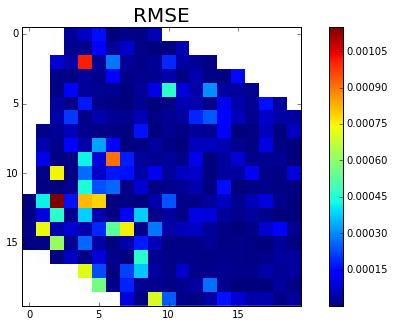

In [106]:
rmse_est = ma.masked_array(rmse_est,mask=ice_grid.mask)
f = plt.figure(figsize=(10,5))
a = f.add_subplot(1,1,1)
plt.imshow(rmse_est, interpolation='none')
a.set_title('RMSE', fontsize=20)
cbar = plt.colorbar()
#cbar.ax.set_ylabel('RMSE', fontsize=20)
f.savefig('C:/Users/apbarret/Documents/Posters/AGU_Fall_2016_Barrett_Stroeve/rmse_for_agu2016.png')
#           bbox_extra_artists=(cbar_ax,), bbox_inches='tight')